## New Pipeline Algorithm:

For this new pipeline, I will be attempting to calculate four different functions of $N/\langle N\rangle$. The four types of objects will be: balrog detected stars, balrog detected stars that were classified as stars, balrog detected galaxies, and balrog detected galaxies that were classified as galaxies. For the first two, my overall pixel sample will include every pixel where a good quality star injection occured. By this I mean that I will look at pixels where at least one star injection passed my typical four quality cuts. For the last two, it will be synonymous but for balrog galaxy injections. Perform some color magnitude cuts, and only look at measured psf magnitude. The color magnitude cut does not have to be based on the isochrone.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
import healpy as hp
import Config
import StellarConfig as strConfig
from scipy import interpolate as inter

## Getting Objects

This will be a bit different than previous methods, for one I will be using a full 4096 resolution (although this would change in the regular pipeline back to 512). I also want the pixels for every object, as well as the color and magnitude for detected objects so that I can later perform a color magnitude cut.

In [2]:
matBalrGalaFile = strConfig.matBalrFile
detBalrGalaFile = strConfig.detBalrFile
matBalrStarFile = strConfig.matBalrStarFile
detBalrStarFile = strConfig.detBalrStarFile

deepFiles = strConfig.deepFiles

pixFile = strConfig.pixFile

classCutoff = strConfig.classCutoff
gCut = strConfig.gCut

## Stars

In [3]:
# This reads in all of the data. Most of these are just flags, but the g magnitude, ra, dec, detected
# flag, and others will be stored for later use.
starData = fitsio.read(detBalrStarFile, columns = ['bal_id', 'flags_foreground', 'flags_badregions', 
                                            'flags_footprint', 'match_flag_1.5_asec', 'true_ra', 'true_dec'])
FOREGROUND = starData['flags_foreground']
BADREGIONS = starData['flags_badregions']
FOOTPRINT = starData['flags_footprint']
ARCSECONDS = starData['match_flag_1.5_asec']

ALL_STAR_RA = starData['true_ra']
ALL_STAR_DEC = starData['true_dec']

qualityCut = np.where((FOREGROUND == 0) & 
                      (BADREGIONS < 2) & 
                      (FOOTPRINT == 1) & 
                      (ARCSECONDS < 2))[0]

ALL_STAR_RA = ALL_STAR_RA[qualityCut]
ALL_STAR_DEC = ALL_STAR_DEC[qualityCut]

measStarData = fitsio.read(matBalrStarFile, columns = ['meas_ra', 'meas_dec', 'meas_EXTENDED_CLASS_SOF',
                                            'meas_psf_mag', 'bal_id'])

RA = measStarData['meas_ra']
DEC = measStarData['meas_dec']
# PSF Magnitudes
GMAG_PSF = measStarData['meas_psf_mag'][:,0]
RMAG_PSF = measStarData['meas_psf_mag'][:,1]
# This is the class that the object was measured as.
CLASS = measStarData['meas_EXTENDED_CLASS_SOF']
# This is the ID from the measured catalog.
MEAS_ID  = measStarData['bal_id']

sortInds = MEAS_ID.argsort()
MEAS_ID = MEAS_ID[sortInds[::1]]
RA = RA[sortInds[::1]]
DEC = DEC[sortInds[::1]]
GMAG_PSF = GMAG_PSF[sortInds[::1]]
RMAG_PSF = RMAG_PSF[sortInds[::1]]
CLASS = CLASS[sortInds[::1]]

# Everything from here on out is simply used in order to filter the data
FLAG_ID = starData['bal_id']

sortInds = FLAG_ID.argsort()
FLAG_ID = FLAG_ID[sortInds[::1]]
FOREGROUND = FOREGROUND[sortInds[::1]]
BADREGIONS = BADREGIONS[sortInds[::1]]
FOOTPRINT = FOOTPRINT[sortInds[::1]]
ARCSECONDS = ARCSECONDS[sortInds[::1]]

cropInds = np.isin(FLAG_ID, MEAS_ID)

# This will serve to align the flags with their measured counterpart.
# parallelInd = 0
# cropInds = []
# for i in np.arange(len(FLAG_ID)):
#     if parallelInd >= len(MEAS_ID):
#         break
#     if MEAS_ID[parallelInd] == FLAG_ID[i]:
#         cropInds.append(i)
#         parallelInd += 1

FOREGROUND = FOREGROUND[cropInds]
BADREGIONS = BADREGIONS[cropInds]
FOOTPRINT = FOOTPRINT[cropInds]
ARCSECONDS = ARCSECONDS[cropInds]

# This is used to filter out any injections that had flags raised.
cutIndices = np.where((FOREGROUND == 0) & 
                      (BADREGIONS < 2) & 
                      (FOOTPRINT == 1) & 
                      (ARCSECONDS < 2) &
                      (CLASS >= 0) &
                      # Isochrone cuts
                      (GMAG_PSF < gCut))[0]

# This reduced the data down to the actually valid pixels.
STAR_RA = RA[cutIndices]
STAR_DEC = DEC[cutIndices]
STAR_GMAG = GMAG_PSF[cutIndices]
STAR_RMAG = RMAG_PSF[cutIndices]
STAR_CLASS = CLASS[cutIndices]

In [4]:
# All I need from the deep fields is the ID numbers and original KNN classification.
deepCols  = ['KNN_CLASS', 'ID']
deepID = []
deepClass= []

for deepFile in deepFiles:
    deepData = fitsio.read(deepFile, columns = deepCols)
    deepID.extend(deepData['ID'])
    deepClass.extend(deepData['KNN_CLASS'])

deepID = np.array(deepID)
deepClass = np.array(deepClass)

# This serves to make it easier to check the original classification of an object.
# This way I can simply check the classification by indexing to an ID number minus
# the minimum ID number to find the classification. This prevented having an overly
# large array but still has the speed advantage of indexing.
minID = np.min(deepID)
deepGalID = np.zeros(np.max(deepID) - minID + 1)
deepGalID[deepID - minID] = deepClass

# This is from the detected dataset
balrData = fitsio.read(detBalrGalaFile, columns = ['true_ra', 'true_dec', 'true_id', 'bal_id', 'flags_foreground', 'flags_badregions', 'flags_footprint', 'match_flag_1.5_asec'])

# These are the data values useful for cropping the data.
FOREGROUND = balrData['flags_foreground']
BADREGIONS = balrData['flags_badregions']
FOOTPRINT = balrData['flags_footprint']
ARCSECONDS = balrData['match_flag_1.5_asec']

ALL_GALA_ID = balrData['true_id']
ALL_GALA_RA = balrData['true_ra']
ALL_GALA_DEC = balrData['true_dec']

qualityCut = np.where((FOREGROUND == 0) & 
                      (BADREGIONS < 2) & 
                      (FOOTPRINT == 1) & 
                      (ARCSECONDS < 2) &
                      (deepGalID[ALL_GALA_ID - minID] == 1))[0]

ALL_GALA_RA = ALL_GALA_RA[qualityCut]
ALL_GALA_DEC = ALL_GALA_DEC[qualityCut]

wideCols = ['true_id', 'bal_id', 'meas_ra', 'meas_dec', 'meas_EXTENDED_CLASS_SOF', 'meas_psf_mag']
measBalrData = fitsio.read(matBalrGalaFile, columns = wideCols)

# This will be used to match galaxies to their deep field counterparts.
ID = measBalrData['true_id']

# This is the Balrog Object ID
BALR_ID = measBalrData['bal_id']

# These are some of the data points I will be storing for valid data.
RA = measBalrData['meas_ra']
DEC = measBalrData['meas_dec']
CLASS = measBalrData['meas_EXTENDED_CLASS_SOF']

GMAG_PSF = measBalrData['meas_psf_mag'][:,0]
RMAG_PSF = measBalrData['meas_psf_mag'][:,1]

sortInds = BALR_ID.argsort()
BALR_ID = BALR_ID[sortInds[::1]]
ID = ID[sortInds[::1]]
RA = RA[sortInds[::1]]
DEC = DEC[sortInds[::1]]
GMAG_PSF = GMAG_PSF[sortInds[::1]]
RMAG_PSF = RMAG_PSF[sortInds[::1]]
CLASS = CLASS[sortInds[::1]]

# This is the Balrog Object ID for all data, not just matches
FLAG_ID = balrData['bal_id']

sortInds = FLAG_ID.argsort()
FLAG_ID = FLAG_ID[sortInds[::1]]
FOREGROUND = FOREGROUND[sortInds[::1]]
BADREGIONS = BADREGIONS[sortInds[::1]]
FOOTPRINT = FOOTPRINT[sortInds[::1]]
ARCSECONDS = ARCSECONDS[sortInds[::1]]

# This will serve to align the flags with their measured counterpart.
# Try sorting both with an argsort and then running this method.

cropInds = np.isin(FLAG_ID, BALR_ID)

# parallelInd = 0
# cropInds = []
# for i in np.arange(len(FLAG_ID)):
#     if parallelInd >= len(BALR_ID):
#         break
#     if BALR_ID[parallelInd] == FLAG_ID[i]:
#         cropInds.append(i)
#         parallelInd += 1

FOREGROUND = FOREGROUND[cropInds]
BADREGIONS = BADREGIONS[cropInds]
FOOTPRINT = FOOTPRINT[cropInds]
ARCSECONDS = ARCSECONDS[cropInds]

cutIndices = np.where(# Quality cuts
                      (FOREGROUND == 0) & 
                      (BADREGIONS < 2) & 
                      (FOOTPRINT == 1) & 
                      (ARCSECONDS < 2) &
                      (CLASS >= 0) &
                      # Isochrone cuts
                      (GMAG_PSF < gCut))[0]

ID = ID[cutIndices]
RA = RA[cutIndices]
DEC = DEC[cutIndices]
GMAG_PSF = GMAG_PSF[cutIndices]
RMAG_PSF = RMAG_PSF[cutIndices]
CLASS = CLASS[cutIndices]

# This makes it so I only store objects that were initially labeled as galaxies in the deep fields.
# It also performs some cuts on extreme values.
trueClass = deepGalID[ID - minID]
useInds = np.where((trueClass == 1))[0]

GALA_RA = RA[useInds]
GALA_DEC = DEC[useInds]
GALA_GMAG = GMAG_PSF[useInds]
GALA_RMAG = RMAG_PSF[useInds]
GALA_CLASS = CLASS[useInds]

In [99]:
# At this point, change ra and dec to pix resolution of choice.
res = 4096

In [100]:
ALL_STAR_PIX = hp.ang2pix(res, ALL_STAR_RA, ALL_STAR_DEC, nest = True, lonlat = True)
STAR_PIX = hp.ang2pix(res, STAR_RA, STAR_DEC, nest = True, lonlat = True)
STAR_GR = STAR_GMAG - STAR_RMAG

ALL_GALA_PIX = hp.ang2pix(res, ALL_GALA_RA, ALL_GALA_DEC, nest = True, lonlat = True)
GALA_PIX = hp.ang2pix(res, GALA_RA, GALA_DEC, nest = True, lonlat = True)
GALA_GR = GALA_GMAG - GALA_RMAG

In [101]:
rMagCut = [24, 24.5]
grCut = [0, 1]

detStarPix = STAR_PIX[np.where((STAR_GR >= grCut[0]) & (STAR_GR <= grCut[1]) & (STAR_RMAG >= rMagCut[0]) & (STAR_RMAG <= rMagCut[1]))[0]]
claStarPix = STAR_PIX[np.where((STAR_GR >= grCut[0]) & (STAR_GR <= grCut[1]) & (STAR_RMAG >= rMagCut[0]) & (STAR_RMAG <= rMagCut[1]) & (STAR_CLASS <= classCutoff))[0]]

detGalaPix = GALA_PIX[np.where((GALA_GR >= grCut[0]) & (GALA_GR <= grCut[1]) & (GALA_RMAG >= rMagCut[0]) & (GALA_RMAG <= rMagCut[1]))[0]]
claGalaPix = GALA_PIX[np.where((GALA_GR >= grCut[0]) & (GALA_GR <= grCut[1]) & (GALA_RMAG >= rMagCut[0]) & (GALA_RMAG <= rMagCut[1]) & (GALA_CLASS <= classCutoff))[0]]

In [102]:
index = 38
# condSignal = fitsio.read(strConfig.condFiles[index])['SIGNAL']
# condPix = fitsio.read(pixFile)['PIXEL']
condition = Config.conditions[index]
condData = fitsio.read(Config.files[index])
condPix = condData['PIXEL']
condSignal = condData['SIGNAL']

condPix = condPix[np.where(condSignal > -100)[0]]
condSignal = condSignal[np.where(condSignal > -100)[0]]

In [103]:
allStarPix = ALL_STAR_PIX[np.isin(ALL_STAR_PIX, condPix)]
detStarPix = detStarPix[np.isin(detStarPix, condPix)]
claStarPix = claStarPix[np.isin(claStarPix, condPix)]

allGalaPix = ALL_GALA_PIX[np.isin(ALL_GALA_PIX, condPix)]
detGalaPix = detGalaPix[np.isin(detGalaPix, condPix)]
claGalaPix = claGalaPix[np.isin(claGalaPix, condPix)]

In [104]:
fullCond = np.zeros(12*res**2)
fullCond[condPix] = condSignal

starCond = fullCond[np.unique(allStarPix)]
galaCond = fullCond[np.unique(allGalaPix)]

In [105]:
detStarCounts = np.zeros(12*res**2)
for pix in detStarPix:
    detStarCounts[pix] += 1
detStarCounts = detStarCounts[np.unique(allStarPix)]

claStarCounts = np.zeros(12*res**2)
for pix in claStarPix:
    claStarCounts[pix] += 1
claStarCounts = claStarCounts[np.unique(allStarPix)]

detGalaCounts = np.zeros(12*res**2)
for pix in detGalaPix:
    detGalaCounts[pix] += 1
detGalaCounts = detGalaCounts[np.unique(allGalaPix)]

claGalaCounts = np.zeros(12*res**2)
for pix in claGalaPix:
    claGalaCounts[pix] += 1
claGalaCounts = claGalaCounts[np.unique(allGalaPix)]

In [106]:
aveDetStar = np.sum(detStarCounts) / len(detStarCounts)
aveClaStar = np.sum(claStarCounts) / len(claStarCounts)

aveDetGala = np.sum(detGalaCounts) / len(detGalaCounts)
aveClaGala = np.sum(claGalaCounts) / len(claGalaCounts)

In [107]:
sigma = 0.5
numBins = 100

In [108]:
xStar = np.linspace(np.average(starCond)-3*np.std(starCond), np.average(starCond)+3*np.std(starCond), numBins)
xStar = xStar[np.where(xStar <= np.max(starCond))[0]]
xStar = xStar[np.where(xStar >= np.min(starCond))[0]]
starSigma = sigma * np.std(starCond)
yDetStar = []
yClaStar = []

for xi in xStar:
    # Gaussian weighting the values close by to each x value.
    totDetWeightedCounts = np.sum(detStarCounts * np.exp(-1*(((starCond - xi) / starSigma)**2)))
    totDetWeightedPixels = np.sum(np.exp(-1*(((starCond - xi) / starSigma)**2)))
    yDetStar.append((totDetWeightedCounts / totDetWeightedPixels) / aveDetStar)

    totClaWeightedCounts = np.sum(claStarCounts * np.exp(-1*(((starCond - xi) / starSigma)**2)))
    totClaWeightedPixels = np.sum(np.exp(-1*(((starCond - xi) / starSigma)**2)))
    yClaStar.append((totClaWeightedCounts / totClaWeightedPixels) / aveClaStar)

yDetStar = np.array(yDetStar)
yClaStar = np.array(yClaStar)

xGala = np.linspace(np.average(galaCond)-3*np.std(galaCond), np.average(galaCond)+3*np.std(galaCond), numBins)
xGala = xGala[np.where(xGala <= np.max(galaCond))[0]]
xGala = xGala[np.where(xGala >= np.min(galaCond))[0]]
galaSigma = sigma * np.std(galaCond)
yDetGala = []
yClaGala = []

for xi in xGala:
    # Gaussian weighting the values close by to each x value.
    totDetWeightedCounts = np.sum(detGalaCounts * np.exp(-1*(((galaCond - xi) / galaSigma)**2)))
    totDetWeightedPixels = np.sum(np.exp(-1*(((galaCond - xi) / galaSigma)**2)))
    yDetGala.append((totDetWeightedCounts / totDetWeightedPixels) / aveDetGala)

    totClaWeightedCounts = np.sum(claGalaCounts * np.exp(-1*(((galaCond - xi) / galaSigma)**2)))
    totClaWeightedPixels = np.sum(np.exp(-1*(((galaCond - xi) / galaSigma)**2)))
    yClaGala.append((totClaWeightedCounts / totClaWeightedPixels) / aveClaGala)

yDetGala = np.array(yDetGala)
yClaGala = np.array(yClaGala)

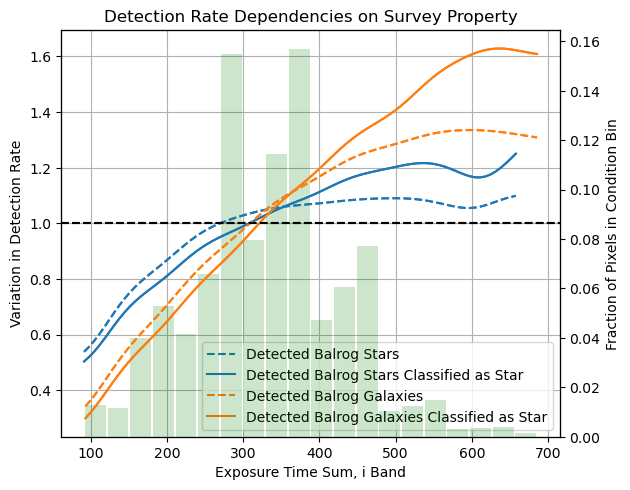

In [109]:
cmap = plt.get_cmap("tab10")

fig, ax1 = plt.subplots()

ax1.set_xlabel(condition)
ax1.tick_params(axis='y')
ax1.set_ylabel('Variation in Detection Rate')
ax1.plot(xStar, yDetStar, label = 'Detected Balrog Stars', color = cmap(0), linestyle = '--')
ax1.plot(xStar, yClaStar, label = 'Detected Balrog Stars Classified as Star', color = cmap(0))
ax1.plot(xGala, yDetGala, label = 'Detected Balrog Galaxies', color = cmap(1), linestyle = '--')
ax1.plot(xGala, yClaGala, label = 'Detected Balrog Galaxies Classified as Star', color = cmap(1))
ax1.axhline(y = 1, color = 'black', linestyle = '--')
ax1.grid()
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.tick_params(axis='y')
ax2.set_ylabel('Fraction of Pixels in Condition Bin')
ax2.hist(condSignal, bins = np.linspace(np.min([np.min(xStar), np.min(xGala)]), np.max([np.max(xStar), np.max(xGala)]), 21), color = 'green', rwidth = 0.923, alpha = 0.2, weights = np.ones(len(condSignal)) / len(condSignal))

ax3 = ax1.twinx()
ax3.tick_params(axis='y', right = False, labelright = False)
ax3.plot(xStar, yDetStar, color = cmap(0), linestyle = '--')
ax3.plot(xStar, yClaStar, color = cmap(0))
ax3.plot(xGala, yDetGala, color = cmap(1), linestyle = '--')
ax3.plot(xGala, yClaGala, color = cmap(1))
ax3.axhline(y = 1, color = 'black', linestyle = '--')


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Detection Rate Dependencies on Survey Property')
plt.show()

In [16]:
# plt.figure(dpi = 120)
# nStars = plt.hist(starRMAG, bins = np.linspace(lowerLim, upperLim, 11), alpha = 0.5)
# binLims = nStars[1]
# nStars = nStars[0]
# nGalas = plt.hist(galaRMAG, bins = np.linspace(lowerLim, upperLim, 11), alpha = 0.5)
# nGalas = nGalas[0]
# plt.show()

In [17]:
# starPerBin = int(np.min(nStars))
# galaPerBin = int(np.min(nGalas))

In [18]:
# allStarInds = np.array([])
# allGalaInds = []
# for i in np.arange(len(binLims) - 1):
#     starInds = np.where((starRMAG >= binLims[i]) & (starRMAG <= binLims[i+1]))[0]
#     np.random.shuffle(starInds)
#     starInds = starInds[:starPerBin]
#     allStarInds = np.append(allStarInds, starInds)
    
#     galaInds = np.where((galaRMAG >= binLims[i]) & (galaRMAG <= binLims[i+1]))[0]
#     np.random.permutation(galaInds)
#     galaInds = galaInds[:galaPerBin]
#     allGalaInds = np.append(allGalaInds, galaInds)

In [19]:
# starDET = starDET[allStarInds.astype(int)]
# starPIX = starPIX[allStarInds.astype(int)]
# starRMAG = starRMAG[allStarInds.astype(int)]

In [20]:
# galaDET = galaDET[allGalaInds.astype(int)]
# galaPIX = galaPIX[allGalaInds.astype(int)]
# galaRMAG = galaRMAG[allGalaInds.astype(int)]

In [21]:
# plt.figure(dpi = 120)
# plt.hist(starRMAG, bins = binLims, alpha = 0.5)#, density = True)
# plt.hist(galaRMAG, bins = binLims, alpha = 0.5)#, density = True)
# plt.show()